In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-10-08 16:44:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.29.16, 172.217.30.176, 172.217.162.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.29.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: 'cats_and_dogs_filtered.zip'

     0K .......... .......... .......... .......... ..........  0% 2,80M 23s
    50K .......... .......... .......... .......... ..........  0% 20,2M 13s
   100K .......... .......... .......... .......... ..........  0% 23,9M 10s
   150K .......... .......... .......... .......... ..........  0% 35,2M 8s
   200K .......... .......... .......... .......... ..........  0% 43,1M 7s
   250K .......... .......... .......... .......... ..........  0% 39,5M 6s
   300K .......... .......... .......... .......... ..........  0% 46,1M 5s
   350K .......... .......... 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
dataset_dir = os.path.join(os.getcwd(), 'gafanhotos_larvas')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_gafanhotos_len = len(os.listdir(os.path.join(dataset_train_dir, 'gafanhotos')))
dataset_train_lagartas_len = len(os.listdir(os.path.join(dataset_train_dir, 'lagartas')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_gafanhotos_len = len(os.listdir(os.path.join(dataset_validation_dir, 'gafanhotos')))
dataset_validation_lagartas_len = len(os.listdir(os.path.join(dataset_validation_dir, 'lagartas')))

print('Train gafanhotos: %s' % dataset_train_gafanhotos_len)
print('Train lagartas: %s' % dataset_train_gafanhotos_len)
print('Validation gafanhotos: %s' % dataset_validation_gafanhotos_len)
print('Validation lagartas: %s' % dataset_validation_gafanhotos_len)




Train gafanhotos: 1005
Train lagartas: 1005
Validation gafanhotos: 409
Validation lagartas: 409


In [4]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

batch_size = 32
epochs = 20
learning_rate = 0.0001

class_names = ['gafanhotos', 'lagartas']

In [5]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)


Found 1914 files belonging to 2 classes.


In [6]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)


Found 582 files belonging to 2 classes.


In [20]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))




Validation Dataset Cardinality: 16
Test Dataset Cardinality: 3


In [23]:
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):

        for i in range(9):

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

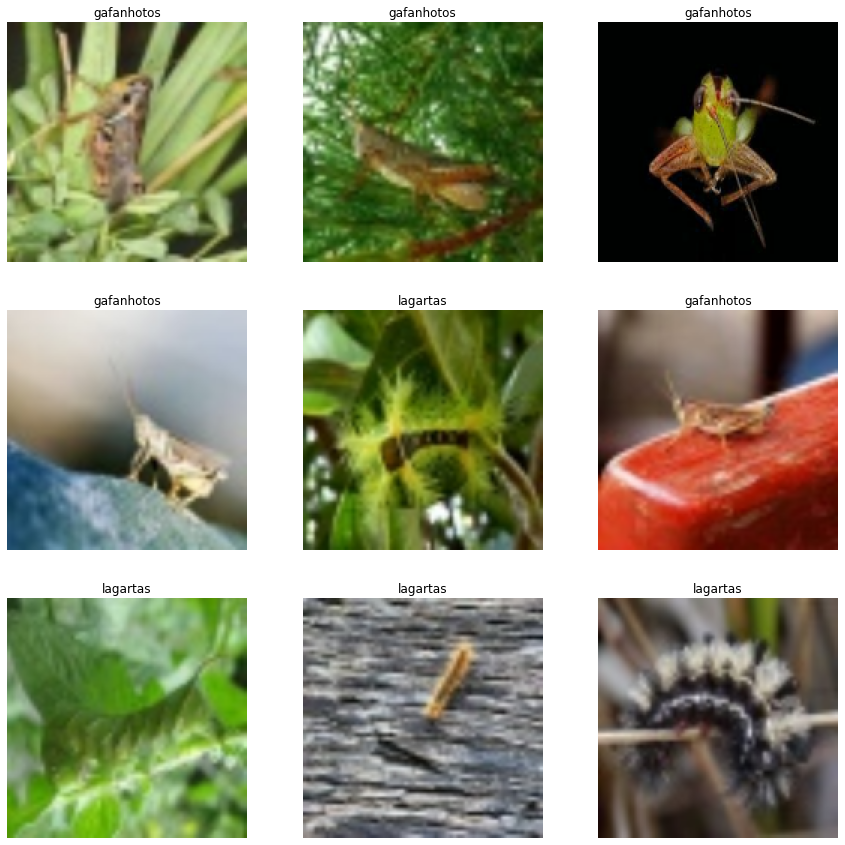

In [26]:
plot_dataset(dataset_train)

<Figure size 432x288 with 0 Axes>

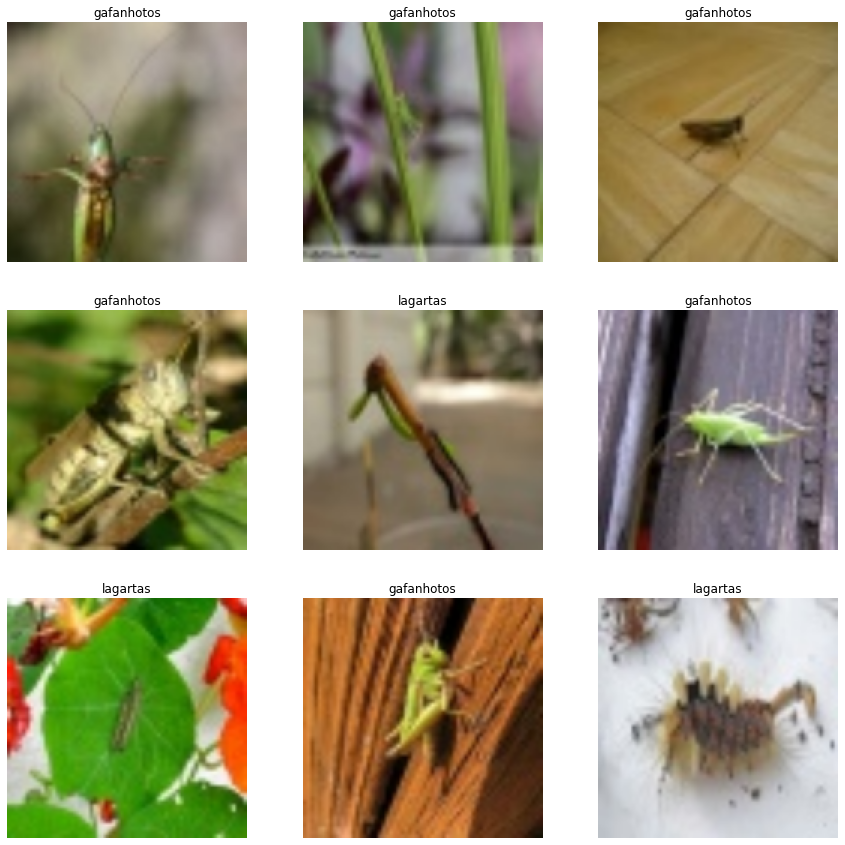

In [27]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

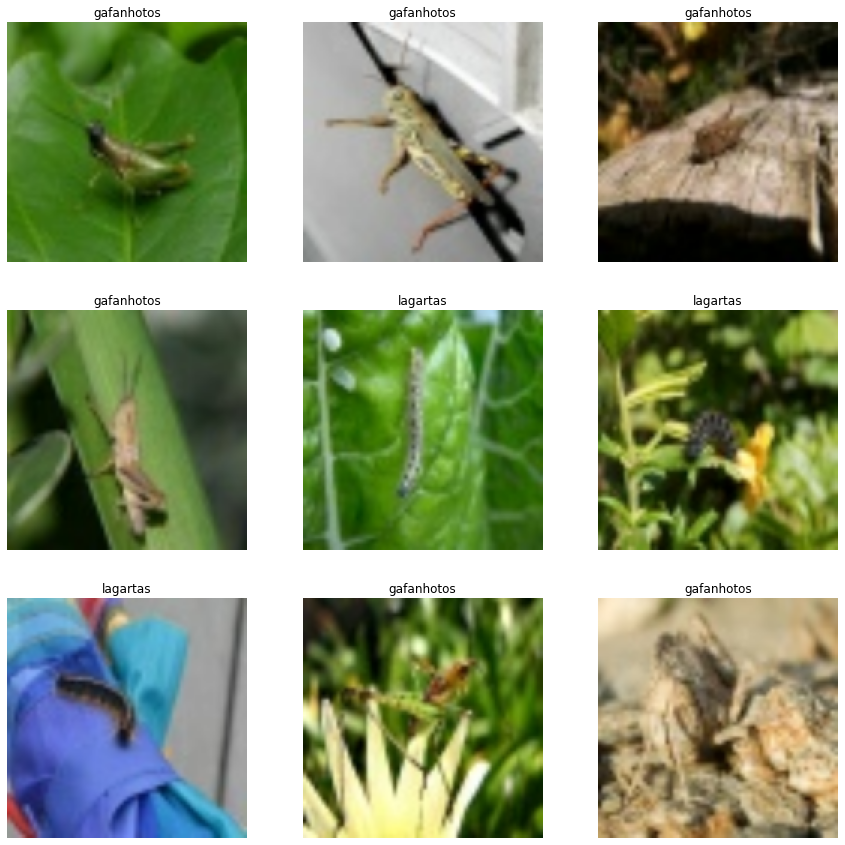

In [28]:
plot_dataset(dataset_test)

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / image_color_channel_size,
        input_shape = image_shape
    ),
    tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuary']
)
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 40, 40, 64)       

In [46]:
def plot_dataset_predictions(dataset):

    features, labels = dataset_test.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(9):

        plt.subplot(3, 3, i + 1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])


Labels:      [0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<Figure size 432x288 with 0 Axes>

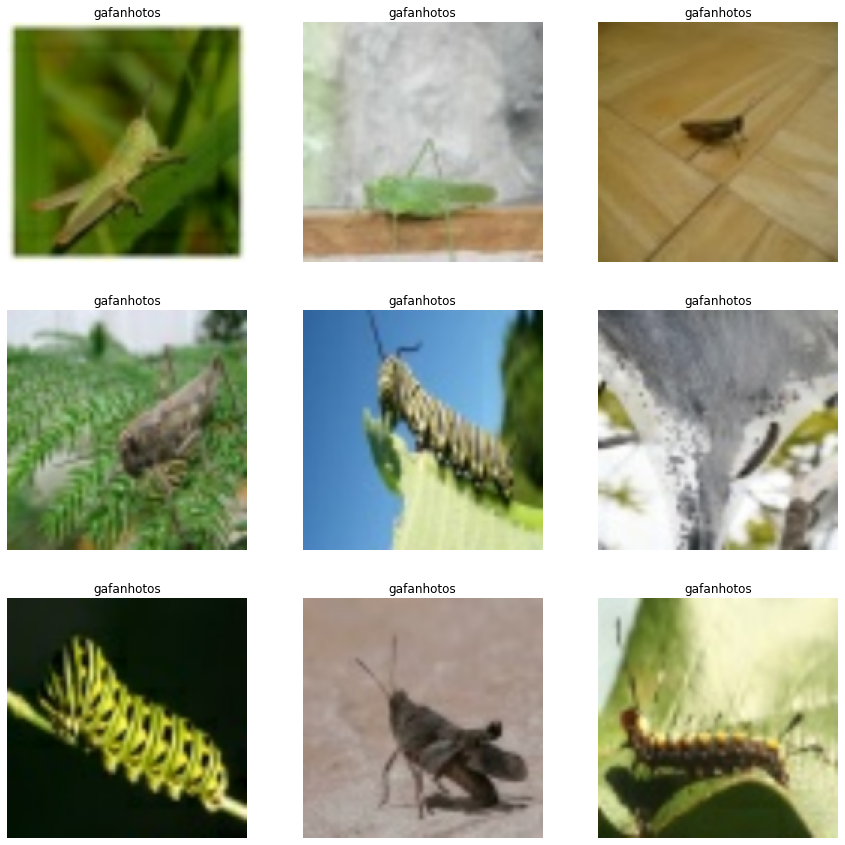

In [47]:
plot_dataset_predictions(dataset_test)